In [1]:
import numpy as np
from copy import deepcopy
import pandas as pd

In [2]:
import time

In [3]:
# helper function 
def product(a,b):
    if a == 0:
        return 1
    if b < a:
        return 0
    return np.product(np.arange(b-a+1,b+1,1))

## $\tau$-leaping for a simple chemical process


this file is the code for the $\tau$-leaping algorithm applied to a very simple chemical process. 

There are two populations
- $x_1$: the number of $O_2$ molucules
- $x_2$: the number of $O$ molucules

And there are two chemical reactions:
- **binding**: $O+O \to O_2$, with reaction rate $k_+(x_2)(x_2-1)$
- **breaking**: $O_2 \to O+O$, with reaction rate $k_-x_1$



## algorithm

In [4]:
# compounds should be a dictionary, 
#     key = name of the compound, 
#     val = quantity of the counpound. 

class reaction:
    def __init__(self,input_compounds, output_compounds, reaction_rate):
        
        self.input = input_compounds
        self.output = output_compounds
        self.rr = reaction_rate
    
    def proba(self,i):
        return self.rr * np.product([product(self.input[key],i[key]) for key in self.input])
    
class chemical_system:
    
    def __init__(self, chemicals, reactions):
        
        self.chemicals = deepcopy(chemicals)
        self.reactions = reactions
    
    def tau_leaping(self,tau):
        
        change = {key:0 for key in self.chemicals}
        # print(self.chemicals)
        
        for reaction in self.reactions:
            
            event_count = np.random.poisson(reaction.proba(self.chemicals)*tau) 
            # print(event_count)
            for key in self.chemicals:
                change[key] -= reaction.input[key]*event_count
                change[key] += reaction.output[key]*event_count
                
        for key in self.chemicals:
            self.chemicals[key] += change[key]
        
        for v in self.chemicals.values():
            if v < 0:
                print('negative chemical quantity')
                assert(False)
        # print()
        
    def tau_simulation(self,tau, T, record=False):
            
        t = 0
        
        if record:
            records = {t:deepcopy(self.chemicals)}
        
        while t + tau <= T:
            self.tau_leaping(tau)
            t += tau
            if record:
                records[t] = deepcopy(self.chemicals)
        if record:
            return pd.DataFrame(data=records)

## setting parameter of the model

In [5]:
chemicals = {
    "O_2":5000,
    "O": 4000
    }

binding = reaction(
    input_compounds={'O':2, 'O_2':0},
    output_compounds={'O':0, 'O_2':1},
    reaction_rate = .0004
)

breaking = reaction(
    input_compounds={'O':0, 'O_2':1},
    output_compounds={'O':2, 'O_2':0},
    reaction_rate = .2
)

reactions = [binding, breaking]

Ts = [1,2]

def init_chemical_system():
    return chemical_system(chemicals,reactions)

## Running simulation

$\tau = 0.005, T = 50, x_1 = 5000, x_2 = 4000, k_- = 0.2, k_+ = 4\cdot 10^{-5}$

In [6]:
chem_sys = init_chemical_system()
s = time.time()
records = chem_sys.tau_simulation(tau = 0.05, T=20, record=True)
e = time.time()
e-s

0.013195991516113281

<AxesSubplot:>

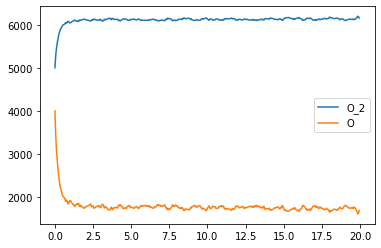

In [7]:
records.T.plot()

In [8]:
arr = records.T.to_numpy()
ratio = arr[:,0]/arr[:,1]

In [9]:
from matplotlib import pyplot as plt

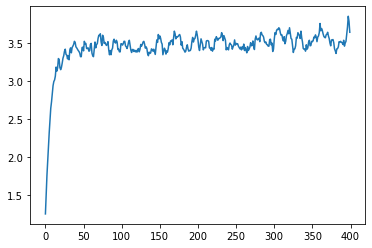

In [10]:
plt.plot(ratio)